In [1]:
#Data management
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

#Data visualization
import pylab as pl
from matplotlib import ticker
%pylab inline

#Tools for feature selection
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as outl
from sklearn import cross_validation

Populating the interactive namespace from numpy and matplotlib


# 1_Load Data

In [2]:
# Load joined data ('data/output/data_ready.csv')
data_ready = pd.read_csv('data/output/data_ready.csv', dtype = {'ZIPCODE': str}, parse_dates = ['Date'])

In [3]:
data_ready.head(2)

,Unnamed: 0,Count_com,Date,Count_vio,Year,Month,Week,ZIPCODE,POPULATION,disability_r,...,below_poverty_r,pop,male_pop_r,female_pop_r,elder_pop_r,white_r,black_r,asian_r,towork_less30_r,towork_over30_r
0,0,9.0,2014-03-17,0.0,2014,3,12,10001,22413.0,0.078,...,0.204,23537.0,0.502485,0.497515,0.000501,0.602456,0.121893,0.191996,0.624704,0.375296
1,1,9.0,2014-03-24,1.0,2014,3,13,10001,22413.0,0.078,...,0.204,23537.0,0.502485,0.497515,0.000501,0.602456,0.121893,0.191996,0.624704,0.375296


In [4]:
# Keep and aggregate 2015 annual data in order to find causality
# The reason why picking 2015 data is 2015 cover all complaints and violations
df = data_ready[data_ready['Year'] == 2015]
df = data_ready.groupby('ZIPCODE')['Count_com', 'Count_vio'].sum()
df['ZIPCODE'] = df.index
print len(df)
print df.head(2)

184
         Count_com  Count_vio ZIPCODE
ZIPCODE                              
10001       1281.0      250.0   10001
10002       3598.0     1667.0   10002


In [5]:
acs_zip = pd.read_csv('data/output/acs_zip.csv', dtype = {'ZIPCODE': str})

In [6]:
#acs_zip.sort(['ZIPCODE'], ascending = 1)

In [7]:
print len(acs_zip)

248


In [8]:
df = pd.merge(df, acs_zip, how='outer', on='ZIPCODE')
df = df[df['POPULATION'] > 0]

In [9]:
#df.sort(['ZIPCODE'], ascending = 1)

In [10]:
# Drop dulicates 
df = df.drop_duplicates()
df = df.drop(['Unnamed: 0'], axis = 1)

In [11]:
print len(df)
print df.head(2)

187
   Count_com  Count_vio ZIPCODE  POPULATION      Id2  disability_r  \
0     1281.0      250.0   10001     22413.0  10001.0         0.078   
1     3598.0     1667.0   10002     81305.0  10002.0         0.156   

   edu_high_r  edu_low_r  employment_r       hh       ...             pop  \
0       0.667      0.135         0.647  11639.0       ...         23537.0   
1       0.328      0.206         0.510  33348.0       ...         80736.0   

   male_pop_r  female_pop_r  elder_pop_r   white_r   black_r   asian_r  \
0    0.502485      0.497515     0.000501  0.602456  0.121893  0.191996   
1    0.480752      0.519248     0.000222  0.295605  0.086108  0.432372   

   native_r  towork_less30_r  towork_over30_r  
0  0.002422         0.624704         0.375296  
1  0.002329         0.463618         0.536382  

[2 rows x 33 columns]


In [12]:
# Reset index and permutate
df_sample = df.reset_index(drop=True)
df_sample = df_sample.iloc[np.random.permutation(len(df_sample))].reset_index(drop=True)

In [13]:
df_sample.head(2) 

,Count_com,Count_vio,ZIPCODE,POPULATION,Id2,disability_r,edu_high_r,edu_low_r,employment_r,hh,...,pop,male_pop_r,female_pop_r,elder_pop_r,white_r,black_r,asian_r,native_r,towork_less30_r,towork_over30_r
0,230.0,27.0,11357,38944.0,11357.0,0.104,0.367,0.266,0.541,14846.0,...,39737.0,0.475023,0.524977,0.000541,0.751315,0.004807,0.192138,0.003724,0.427093,0.572907
1,9701.0,5012.0,11212,83866.0,11212.0,0.120,0.125,0.366,0.461,31443.0,...,88668.0,0.422362,0.577638,0.000130,0.049409,0.836040,0.012823,0.003259,0.201659,0.798341


In [14]:
len(df_sample)

187

In [15]:
# Compute Heat/hot water complaints per household
df_sample['com_ph'] = df_sample['Count_com'] / df_sample['hh']

# Compute Class C violations per household
df_sample['vio_ph'] = df_sample['Count_vio'] / df_sample['hh']

In [18]:
# Define the set of variables that are percentages
var_pc = ['disability_r', 'edu_high_r', 'employment_r', 'hh_with6_r', 'utility_gas_r', 'tank_gas_r',
         'fueloil_r', 'occupied_hu_rent_r',
         'built_before1980_r', 'married_r', 'non_eng_r', 'below_poverty_r', 'female_pop_r',
         'elder_pop_r', 'white_r', 'black_r', 'asian_r', 'towork_less30_r']

# Define the set of variables that are medians
var_med = []

# Define a set of variables that are neigther percentages nor medians
var_add = []

# Define the set of variables interested in
var_int = var_pc + var_med + var_add

In [19]:
df_sample.to_csv('data/output/annual_2015.csv')

In [20]:
df_sample.describe()

/Users/bh1555/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Count_com,Count_vio,POPULATION,Id2,disability_r,edu_high_r,edu_low_r,employment_r,hh,hh_with6_r,...,female_pop_r,elder_pop_r,white_r,black_r,asian_r,native_r,towork_less30_r,towork_over30_r,com_ph,vio_ph
count,180.000000,177.000000,187.000000,187.000000,182.000000,182.000000,182.000000,182.000000,182.000000,180.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,179.000000,176.000000
mean,3257.272222,1352.864407,43693.080214,10758.973262,0.103538,0.386522,0.232659,0.584505,17226.840659,0.002707,...,0.520116,0.000788,0.472016,0.220062,0.139840,0.004946,0.337751,0.662249,0.158314,0.065863
std,3952.340027,1872.579945,27057.971990,970.662059,0.043769,0.217644,0.093991,0.088274,9641.484931,0.004584,...,0.039948,0.003597,0.266095,0.254808,0.134766,0.005349,0.122996,0.122996,0.159234,0.078971
min,7.000000,1.000000,12.000000,83.000000,0.000000,0.086000,0.019000,0.154000,0.000000,0.000484,...,0.134409,0.000000,0.018846,0.000749,0.000000,0.000410,0.144436,0.315239,0.001390,0.000329
25%,NaN,NaN,23888.500000,10291.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,39834.000000,11105.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,62250.500000,11359.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,18620.000000,8095.000000,109069.000000,11697.000000,0.404000,0.898000,0.456000,0.870000,43456.000000,0.041203,...,0.643554,0.045455,0.989016,0.912797,0.733180,0.059140,0.684761,0.855564,0.863955,0.351942


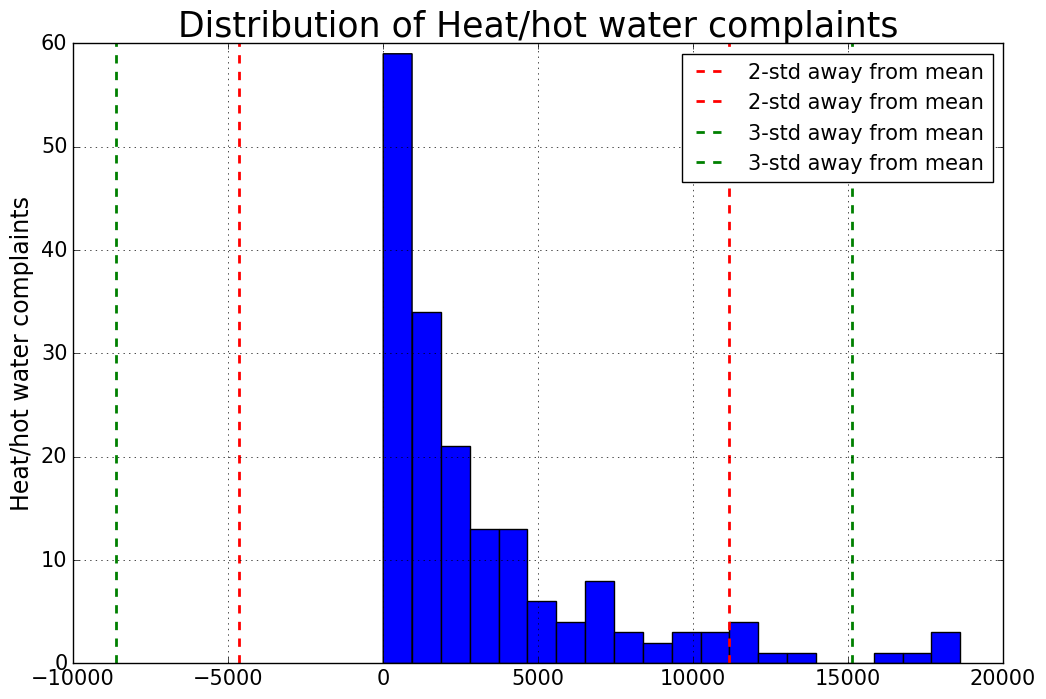

In [21]:
# Plot the distribution of Heat/hot water complaints (total)

fig = pl.figure(figsize = (12,8))
df_sample.Count_com.hist(bins = 20)

# Plot lines two std from the mean
pl.axvline(df_sample.Count_com.mean() + 2*df_sample.Count_com.std(), color = 'red', linewidth = 2.0, linestyle = '--',
          label = "2-std away from mean")
pl.axvline(df_sample.Count_com.mean() - 2*df_sample.Count_com.std(), color = 'red', linewidth = 2.0, linestyle = '--',
          label = "2-std away from mean")

# Plot lines three std from the mean
pl.axvline(df_sample.Count_com.mean() + 3*df_sample.Count_com.std(), color = 'green', linewidth = 2.0, linestyle = '--',
          label = "3-std away from mean")
pl.axvline(df_sample.Count_com.mean() - 3*df_sample.Count_com.std(), color = 'green', linewidth = 2.0, linestyle = '--',
          label = "3-std away from mean")

# Y-axis parameters
pl.tick_params(axis = 'both', which='major', labelsize=13)
pl.ylabel('Number of ZIPCODE', fontsize = 17)

# X-axis parameters
pl.tick_params(labelsize=15)
pl.ylabel('Heat/hot water complaints', fontsize = 17)

# Legend, title, and export
pl.title('Distribution of Heat/hot water complaints', fontsize=25)
pl.legend(fontsize=15)
#pl.savefig('data/output/...')

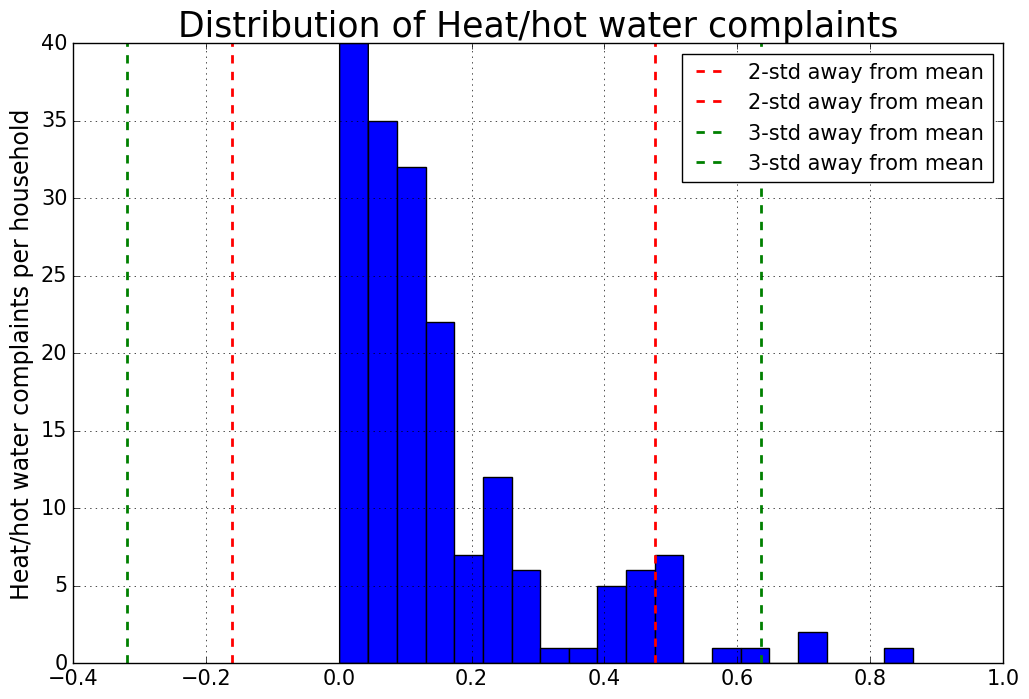

In [22]:
# Plot the distribution of Heat/hot water complaints (per household)

fig = pl.figure(figsize = (12,8))
df_sample.com_ph.hist(bins = 20)

# Plot lines two std from the mean
pl.axvline(df_sample.com_ph.mean() + 2*df_sample.com_ph.std(), color = 'red', linewidth = 2.0, linestyle = '--',
          label = "2-std away from mean")
pl.axvline(df_sample.com_ph.mean() - 2*df_sample.com_ph.std(), color = 'red', linewidth = 2.0, linestyle = '--',
          label = "2-std away from mean")

# Plot lines three std from the mean
pl.axvline(df_sample.com_ph.mean() + 3*df_sample.com_ph.std(), color = 'green', linewidth = 2.0, linestyle = '--',
          label = "3-std away from mean")
pl.axvline(df_sample.com_ph.mean() - 3*df_sample.com_ph.std(), color = 'green', linewidth = 2.0, linestyle = '--',
          label = "3-std away from mean")

# Y-axis parameters
pl.tick_params(axis = 'both', which='major', labelsize=13)
pl.ylabel('Number of ZIPCODE', fontsize = 17)

# X-axis parameters
pl.tick_params(labelsize=15)
pl.ylabel('Heat/hot water complaints per household', fontsize = 17)

# Legend, title, and export
pl.title('Distribution of Heat/hot water complaints', fontsize=25)
pl.legend(fontsize=15)
#pl.savefig('data/output/...')

# 2_Standardize variables

In [23]:
# Drop rows including NaN
for var in var_int + ['com_ph', 'vio_ph']:
    df_sample = df_sample[pd.notnull(df_sample[var])]

# For each independent variables + com_ph + vio_ph    
print len(df_sample)

# Check whether there are null values
for var in var_int + ['vio_ph']:
    a = df_sample.loc[df_sample[var].isnull(), var].shape[0]
    if a != 0:
        print var
    else:
        pass

176


In [24]:
# Due to percentages and medians format variables, need to standardize the variables
# Substract the mean and divide by the std
var_std = StandardScaler().fit_transform(df_sample[var_int + ['vio_ph']])
df_std = pd.DataFrame(var_std, columns=[var_int + ['vio_ph']])

# The target variables (com_ph) are not standardized
df_std['com_ph'] = df_sample['com_ph']

In [25]:
# Drop rows including NaN
for var in var_int + ['com_ph', 'vio_ph']:
    df_std = df_std[pd.notnull(df_std[var])]

# 3_Feature selection
### Ridge regression

In [26]:
# Use cross validation to choose a parameter for the ridge regression based on the features
ridge_model = RidgeCV(cv = 15, normalize = True)
ridge_fit = ridge_model.fit(df_sample[var_int + ['vio_ph']], df_sample.com_ph)
ralpha = ridge_fit.alpha_

In [27]:
# Run the ridge regression with the chosen alpha
ridge = RidgeCV(alphas = [ralpha], cv=15, normalize=True)
ridge.fit(df_sample[var_int + ['vio_ph']], df_sample.com_ph)

# Sort the features based on their absolute coefficient in the ridge regression, keep only the top 15
# Becasue the features are standardized, the ranking of the coefficient corresponds somewhat to the strength
# of their link with the target variables (complaints per household)
var_ridge = []
for i, (k, varb) in enumerate(sorted(zip(map(lambda x: round(x, 4), np.abs(ridge.coef_)), var_int + ['vio_ph']),
                                     reverse=True)):
    if i < 15:
        var_ridge.append(varb)
        print k, "\t", varb

0.9717 	vio_ph
0.3944 	fueloil_r
0.2485 	occupied_hu_rent_r
0.1803 	below_poverty_r
0.161 	married_r
0.1299 	disability_r
0.0862 	edu_high_r
0.072 	utility_gas_r
0.0643 	female_pop_r
0.0635 	asian_r
0.0262 	non_eng_r
0.0258 	white_r
0.0248 	built_before1980_r
0.0229 	black_r
0.0177 	employment_r


In [56]:
#Compute the y predictions and the R-squared for the Ridge Regression results
y_pred = cross_validation.cross_val_predict(ridge, df_sample[var_int + ['vio_ph']], df_sample.com_ph)
ssr = np.sum((y_pred-df_sample.com_ph)**2)
sst = np.sum((df_sample.com_ph - np.mean(df_sample.com_ph))**2)
print "--------------------------------"
print "R-squared \t {0:.2f}%".format((1 - (ssr/sst))*100)

--------------------------------
R-squared 	 85.16%


### Variance Inflation Factor

In [28]:
#Define a function to store Variance Inflation Factors for each feature
def vif_func2(in_frame):
    
    #Load data
    in_dat = in_frame
    df = np.asarray(in_frame)
    vif_final = []
    
    while df.shape[1]>0:
        vif_vals = []
        
        #Compute the VIF for all 15 "Ridge" variables in the set
        for i in range(df.shape[1]):
            vif_vals.append(outl.variance_inflation_factor(df, i))
            
        #Select the feature with the highest VIF
        vif_max = np.max(vif_vals)
        max_name = in_dat.columns[np.argmax(vif_vals)]
        vif_final.append([max_name, vif_max])
        
        #Exclude that feature (with highest VIF) from the list of features
        in_dat = in_dat[[c for c in in_dat.columns if c != max_name]]
        df = np.asarray(in_dat)
        if df.shape[1]==1:
            vif_final.append([in_dat.columns[0], 0])
            return vif_final
            break

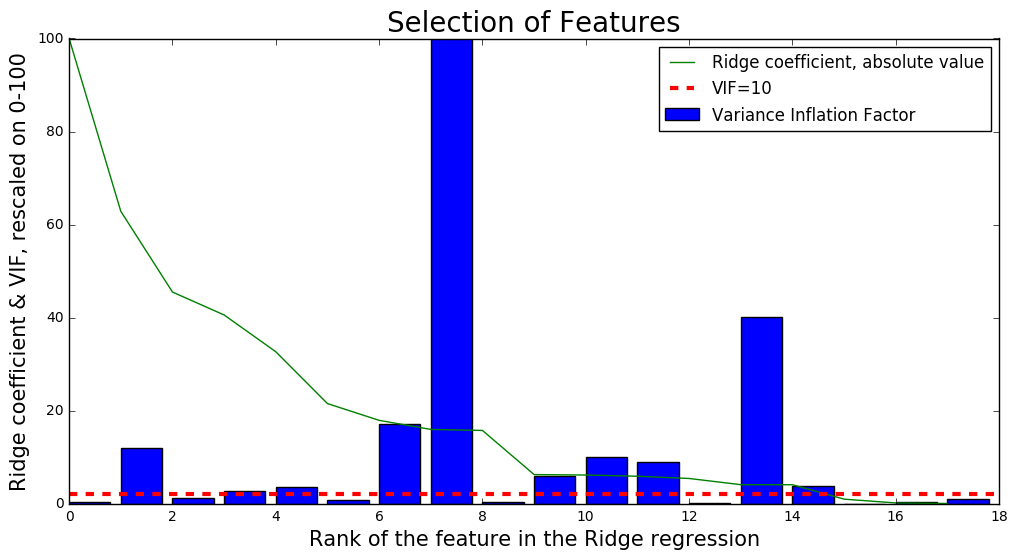

In [29]:
#Gather the features names, their coefficient in the Ridge regression
rr = pd.DataFrame(data={'varb': var_int + ['vio_ph'], 'ridge': ridge.coef_, 'ridge_abs' : np.abs(ridge.coef_)})
rr = rr.sort_values('ridge_abs', ascending=False).reset_index()

#Add the VIF for each feature
rr = rr.merge(pd.DataFrame(vif_func2(df_sample[var_int]), columns=['varb', 'vif']), on='varb')

#Plot ridge coefficient (rescaled from 0 to 100)
fig = pl.figure(figsize=(12,6))
pl.plot(100*(rr.ridge_abs - rr.ridge_abs.min())/(rr.ridge_abs.max() - rr.ridge_abs.min()), 
        color='green', label='Ridge coefficient, absolute value')

#Plot the VIF of each feature (rescaled from 0 to 100)
pl.bar(range(len(rr)), 100*(rr.vif - rr.vif.min())/(rr.vif.max() - rr.vif.min()), label='Variance Inflation Factor')

#Plot the usual VIF threshold (features with a VIF above 10 should be excluded)
pl.axhline(100*(10-rr.vif.min())/(rr.vif.max() - rr.vif.min()), 
           color='red', linestyle='--', linewidth=3, label='VIF=10')

#Figure parameters
pl.xlabel('Rank of the feature in the Ridge regression', fontsize=15)
pl.ylabel('Ridge coefficient & VIF, rescaled on 0-100', fontsize=15)
pl.title('Selection of Features', fontsize=20)
pl.legend(fontsize=12)

### Compute VIF step by step & exclude high VIFs
* In this section I compute the Variance Inflation Factor for the 15 features selected by the Ridge Regression. If there are features with a VIF above 5, I exclude the one with the highest VIF. I then recompute the VIF for each feature, and if there are features with a VIF above 5, I exclude again the one with the highest VIF. I repeat until there is no feature with a VIF above 5.

In [30]:
#Other VIF function to exclude the variables with a VIF too high
def vif_func(in_frame, thresh=10):
    df = np.asarray(in_frame)
    vif_init = []
    
    #Initial list of VIF coefficients
    for i in range(df.shape[1]):
        vif_init.append(outl.variance_inflation_factor(df, i))
        
    #Find the maximum VIF
    vif_max = np.max(vif_init)
    
    #If the initial VIF is below the threshold, no feature to exclude
    if vif_max < thresh:
        print "All variables have VIF < {}".format(thresh)
        print "Max VIF :", in_frame.columns[np.argmax(vif_init)], vif_max
    
    else:
        in_dat = in_frame
    
    #Recursively exclude feature until none has a VIF above the threshold
    while vif_max > thresh:
        vif_vals = [] 
        var_names = in_dat.columns
        df = np.asarray(in_dat)
        
        #Compute VIFs
        for i in range(df.shape[1]):
            vif_vals.append(outl.variance_inflation_factor(df, i))
            
        #Find the maximum
        vif_max = np.max(vif_vals)
        
        #If all VIFs are below the threshold, return the list of features names
        if vif_max < thresh: 
            return in_dat.columns
            break
        
        #Otherwise, remove the feature with the highest VIF from the list of features
        else:
            max_name = in_dat.columns[np.argmax(vif_vals)]
            print "Removed: ", max_name, vif_max
            in_dat = in_dat[[c for c in in_dat.columns if c != max_name]]

In [31]:
#Exclude the features selected by Ridge that have a VIF above 10
vif_func(df_sample[var_ridge], thresh=10)

Removed:  female_pop_r 464.805794241
Removed:  employment_r 151.168071876
Removed:  utility_gas_r 80.4383130487
Removed:  occupied_hu_rent_r 54.5976624935
Removed:  white_r 44.1604788405
Removed:  built_before1980_r 37.0708502375
Removed:  non_eng_r 26.9391755481
Removed:  disability_r 16.0806020362


Index([u'vio_ph', u'fueloil_r', u'below_poverty_r', u'married_r',
       u'edu_high_r', u'asian_r', u'black_r'],
      dtype='object')

# 4_Causality modeling

In [58]:
modl = smf.ols(formula = 'com_ph ~  vio_ph + fueloil_r + occupied_hu_rent_r + built_before1980_r',
              data = df_sample).fit()
modl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 com_ph   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     303.1
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           1.78e-76
Time:                        16:49:22   Log-Likelihood:                 258.08
No. Observations:                 176   AIC:                            -506.2
Df Residuals:                     171   BIC:                            -490.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -0.0881      0.030     -2.960      0.004        -0.147    -0.029
vio_ph                 1.3921      0.080     17.480      0.000         1.235     1.549
fueloil_r              0.2272      0.037      6.078      0.000         0.153     0.301
occupied_hu_rent_r     0.0738      0.024      3.023      0.003         0.026     0.122
built_before1980_r     0.0687      0.031      2.210      0.028         0.007     0.130
==============================================================================
Omnibus:                      120.061   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1488.206
Skew:                           2.307   Prob(JB):                         0.00
Kurtosis:                      16.477   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Ridge
* Lasso
* OLS
* VIF
* Standardization stuff